In [2]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly import subplots
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn import metrics
from scipy import stats

from copy import deepcopy

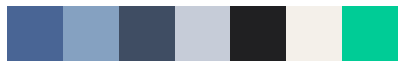

In [3]:
# Defining all our palette colours.
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

primary_green = px.colors.qualitative.Plotly[2]

plt.rcParams['axes.facecolor'] = primary_bgcolor

colors = [primary_blue, primary_blue2, primary_blue3, primary_grey, primary_black, primary_bgcolor, primary_green]
sns.palplot(sns.color_palette(colors))

In this notebook i will try to show a Graph Story about all the questions and answers in this dtaset.

The main flow will be:
1. Show the answers of each question
2. Show some sunburst plots and charts about the relation between some answers
3. Try to conclude

In [4]:
df = pd.read_csv('/kaggle/input/kaggle-survey-2020/kaggle_survey_2020_responses.csv')
descriptions = df.loc[0, :]
df = df.loc[1:, :]
df.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,...,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER
1,1838,35-39,Man,Colombia,Doctoral degree,Student,5-10 years,Python,R,SQL,...,NaN,NaN,NaN,TensorBoard,NaN,NaN,NaN,NaN,NaN,NaN
2,289287,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,Python,R,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,860,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
4,507,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,Python,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,78,30-34,Man,Japan,Master’s degree,Software Engineer,3-5 years,Python,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#Create proffesionals df
q23_columns = [column for column in df.columns if 'Q23' in column]
df_prof = df[df[q23_columns].isnull().sum(axis=1) != len(q23_columns)]
df.loc[df[q23_columns].isnull().sum(axis=1) != len(q23_columns), 'Prof_Stud'] = 'Professional'

# Create Students df
df_stud = df[df['Q5'] == 'Student']
df.loc[df['Q5'] == 'Student', 'Prof_Stud'] = 'Student'

# Q1: What is your age (# years)?

In [6]:
q = pd.DataFrame(df['Q1'].value_counts()).reset_index().sort_values('index')
q.columns = ['ages', 'value']

fig = go.Figure(go.Scatter(
    x = q['ages'],
    y = q['value'],
    mode = 'lines+markers+text',
    text = q['value'],
    textposition="top right",
))
fig.update_layout(
    xaxis={'categoryorder':'category ascending'}
)
fig.show()

As we can see in the scatter plot, it seems to be a normal distribution with mean the mean arround 17 years.

Its obius that there some kagglers under 18 but probably the minority. Also we can see that there is a huge number of persons from 40 years old and above, which is a really good notice :)

In [7]:
def generate_feature_resume(df, feature):
    
    plot_title = f"<span style='font-size:30px; font-family:Serif'><b>{feature.capitalize()}</b> resume</span>"
    (osm, osr), (slope, intercept, r) = stats.probplot(df[feature], plot=None)
    
    q1_value = train_df[feature].quantile(0.25)
    mean_value = train_df[feature].mean()
    fig2 = ff.create_distplot([df[feature]], [feature], colors=[primary_blue],
                             bin_size=.05, show_rug=False)

    fig = make_subplots(
        rows=3, cols=2,
        specs=[
            [{"rowspan": 2}, {"rowspan": 2}],
            [None, None],
            [{"colspan": 2}, None]
        ],
        subplot_titles=(
            "Quantile-Quantile Plot",
            "Box Plot",
            "Distribution Plot"
        )
    )

    fig.add_trace(go.Scatter(
        x=osm,
        y=slope*osm + intercept,
        mode='lines',
        line={
            'color': '#c81515',
            'width': 2.5
        }

    ), row=1, col=1)
    
    ## QQ-Plot
    fig.add_trace(go.Scatter(
        x=osm,
        y=osr,
        mode='markers',
        marker={
            'color': primary_blue
        }
    ), row=1, col=1)

    ## Box Plot
    fig.add_trace(go.Box(
        y=df[feature], 
        name='',
        marker_color = primary_blue
    ), row=1, col=2)

    ## Distribution plot
    fig.add_trace(go.Scatter(
        fig2['data'][1],
        line=dict(
            color=primary_blue, 
            width=1.5,
        ),
        fill='tozeroy'
    ), row=3, col=1)
    
    ## InterQuartile Range (IQR)
    fig.add_vrect(
        x0=df[feature].quantile(0.25), 
        x1=df[feature].quantile(0.75), 
        annotation_text="IQR", 
        annotation_position="top left",
        fillcolor=primary_grey, 
        opacity=0.25, 
        line_width=2,
        row=3, col=1,
    )
    
    ## Mean line
    fig.add_vline(
        x=mean_value,
        line_width=2, 
        line_dash="dash", 
        line_color=primary_black,
        annotation_text="Mean", 
        annotation_position="bottom right",
        row=3, col=1,
    )
    
    fig.add_annotation(
        xref="x domain", yref="y domain",
        x=0.98, y=0.98,
        text=f"<span style='font-family:Serif>Skew: %.2f</span>"%(df[feature].skew()),
        showarrow=False,
        bordercolor=primary_black,
        borderwidth=1, borderpad=2,
        row=3, col=1,
    )
    
    fig.update_layout(
        showlegend=False, 
        title_text=plot_title,
        height=720,
    )

    fig.show()

# Q2: What is your gender?

In [8]:
q = df['Q2'].value_counts().sort_values()

colors = px.colors.qualitative.Plotly
colors = list(reversed(['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A']))

fig = go.Figure(go.Bar(
    x = q.values,
    y = q.index,
    text = q.values,
    textposition="auto",
    texttemplate = "%{value:,s}",
    marker_color = colors,
    orientation='h',
))
fig.update_traces(
    marker_line_color = 'black',
    marker_line_width = 1, 
    opacity = 0.8,
)
fig.show()

As it happens in the engineering dregrees, there are more mean than women.

# Q3: In which country do you currently reside?

In [9]:
q = pd.DataFrame(df['Q3'].value_counts()[:10].sort_values(ascending=False)).reset_index()
q.loc[q['index'] == 'United States of America', 'index'] = 'United States'
q.loc[q['index'] == 'United Kingdom of Great Britain and Northern Ireland', 'index'] = 'United Kingdom'

regions_df = pd.read_csv('/kaggle/input/countries-iso-codes-continent-flags-url/countries_continents_codes_flags_url.csv')
q = q.merge(regions_df, left_on='index', right_on='country', how='left')

fig = go.Figure(go.Bar(
    x = q['index'],
    y = q['Q3'],
    text = q.values,
    textposition="auto",
    texttemplate = "%{value:,s}",
))
fig.update_traces(
    marker_color='rgb(158,202,225)', 
    marker_line_color='rgb(8,48,107)',
    marker_line_width=1.5, 
    opacity=0.6,
)
max_y_val = q['Q3'].max()
for country, flag_url, ppl_vac in zip(q['index'], q['image_url'], q['Q3']):
    if not flag_url or not isinstance(flag_url, str):
        continue
    fig.add_layout_image(
        dict(
            source=flag_url,
            x=country, 
            y=ppl_vac + 0.1 * max_y_val,
            sizex=0.5, 
            sizey=0.08 * max_y_val,
            xanchor="center", yanchor="bottom",
            sizing='stretch',
            xref='x',
            yref="y",
        ),
    )

fig.update_yaxes(range=[0, max_y_val + 0.2*max_y_val])
fig.update_layout(
    title = 'Top 10: Residence country',
)
fig.show()

It seems that India is the country with the highest number of kagglers ahead of EEUU. Its really nice to see that so many countries are participating in this community. This make the community better and more variated! (Here a kaggler from Spain) 

# Q4: What is the highest level of formal education that you have attained or plan to attain within the next 2 years?

In [10]:
q = df['Q4'].value_counts()[:10]

fig = go.Figure(go.Pie(
    labels = q.index,
    values = q.values,
    # hole=.1,
    pull=[0.1, 0, 0, 0]
))
fig.update_traces(
    hoverinfo='label+percent', 
    textinfo='value', 
    textfont_size=15,
    marker=dict(
        line=dict(color='#000000', width=1)
    )
)
fig.update_layout(
    title = 'Kagglers education',
)
fig.show()

As this is mostly a Scientific community, most of the community have a masters or bachelor's degree. 

# Q5: Select the title most similar to your current role

In [11]:
q = df['Q5'].value_counts()

colors = px.colors.qualitative.Light24

fig = go.Figure(go.Bar(
    y = q.values,
    x = q.index,
    text = q.values,
    textposition="auto",
    texttemplate = "%{value:,s}",
    marker_color = colors,
    # orientation='h',
))
fig.update_traces(
    marker_line_color = 'black',
    marker_line_width = 1, 
    opacity = 0.8,
)
fig.show()

## Q4 & Q5

In [12]:
# I want to thank @spitfire2nd for the idea of this plot and some code guidelines
# A guide for this kind of plot, here: https://plotly.com/python/horizontal-bar-charts/

fields = df["Q5"].unique()
education_df = pd.DataFrame()

colours_coffe = ["#a2885e", "#e9cf87", "#f1efd9", "#8eb3aa", "#235f83", primary_blue3]

for field in fields:
    education_df[field] = df[df["Q5"] == field]["Q4"].value_counts()
education_df = education_df.dropna(axis=1, how='all')
education_df = education_df.drop('I prefer not to answer')
education_df = education_df / education_df.sum()

education_df = education_df.reindex(["Doctoral degree", "Master’s degree", 
                                     "Professional degree", "Bachelor’s degree", 
                                     "Some college/university study without earning a bachelor’s degree", 
                                     "No formal education past high school"])

# Adding spacing and formatting directly to the column names.
#education_df.columns = [("<span style='font-size:14px; font-family:Helvetica'>"+label + "</span>  ") for label in education_df.columns]

traces = []
for i, field in enumerate(education_df.index):
    traces.append(go.Bar(
        y = education_df.columns,
        x = education_df.loc[field],
        name = field,
        marker = dict(color = colours_coffe[i]),
        orientation = "h"
    ))

large_title_format = "<span style='font-size:30px; font-family:Times New Roman'>What educational qualifications do I need?</span>"
layout = dict(
    title = dict(text=large_title_format, x=0.5, y=0.963),
    xaxis = dict(
        title="<span style='font-size:13px; font-family:Helvetica'><b>Color Key: </b>Educational qualifications of professionals</span>", 
        side="top",
        title_standoff=0, 
        domain=[0,0.95], 
        showticklabels = False
    ),
    xaxis2 = dict(domain=[0, 1], tickformat = '%'),
    yaxis = dict(domain=[0.85,1], showticklabels = False),
    yaxis2={
        'categoryorder':'array',
        'categoryarray': education_df.loc["Doctoral degree"].sort_values(ascending=True).keys(),
        'domain':[0,0.83]
    },
    barmode = "stack",
    bargap = 0.05,
    showlegend = False,
    width = 700,
    height = 600,
    # plot_bgcolor = "#fff"
)

# Adding a separate subplot that will act as a color key
colorscale = ff.create_annotated_heatmap(
    z=[[1,2,3,4,5,6]],
    annotation_text = [[text 
                       for text in ["Doctoral<br>degree","Master's<br>degree","Professional<br>degree","Bachelor's<br>degree","Education<br>without<br>degree","High school<br>education"]
                      ]],
    colorscale= [
        [0.000,"#a2885e"],[0.166,"#a2885e"],
        [0.166,"#e9cf87"],[0.333,"#e9cf87"],
        [0.333,"#f1efd9"],[0.500,"#f1efd9"],
        [0.500,"#8eb3aa"],[0.666,"#8eb3aa"],
        [0.666,"#235f83"],[0.833,"#235f83"],
        [0.833,primary_blue3],[1.000,primary_blue3],
    ],
    font_colors = ["white", "white", "black", "white", "white", "white"],
    xgap = 1.5,
    showscale = False
)

fig = subplots.make_subplots(
    rows=2, 
    cols=1, 
    shared_yaxes=True, 
    shared_xaxes=False, 
    horizontal_spacing=0.02, 
    vertical_spacing=0.01
)

fig.append_trace(colorscale.data[0],1,1); 

for trace in traces:
    fig.add_trace(trace, 2, 1)

# Workaround to show annotations with ff.create_annotated_heatmap() subplots.
annot1 = list(colorscale.layout.annotations)
for k in range(len(annot1)):
    annot1[k]['xref'] = 'x'
    annot1[k]['yref'] = 'y'
fig.update_layout(annotations=annot1) 

fig.update_layout(layout)
fig.show()

# Q6: For how many years have you been writing code and/or programming?

In [13]:
q = df['Q6'].value_counts()

fig = go.Figure(go.Pie(
    labels = q.index,
    values = q.values,
    hole=.3,
    # pull=[0.2, 0, 0, 0]
))
fig.update_traces(
    hoverinfo='value+percent', 
    textinfo='label+percent', 
    textfont_size=13,
    marker=dict(
        line=dict(color='#000000', width=.7)
    )
)
fig.update_layout(
    title = 'Kagglers programming experience',
)
fig.show()

# Q7: What programming languages do you use on a regular basis? (Select all that apply)

In [14]:
q = {}
for i in range(1,13):
    q.update(dict(df[f"Q7_Part_{i}"].value_counts()))
q = pd.DataFrame(q.items(), columns = ['languague', 'counts'])
q['colour'] = px.colors.qualitative.Light24[:12]

top_lang = q['languague'][:5]

fig = go.Figure(go.Bar(
    y = q['counts'],
    x = q['languague'],
    text = q['counts'],
    textposition="auto",
    texttemplate = "%{value:,s}",
    marker_color = q['colour'],
    # orientation='h',
))
fig.update_traces(
    marker_line_color = 'black',
    marker_line_width = 1, 
    opacity = 0.9,
)
fig.update_layout(
    xaxis={'categoryorder':'total descending'}
)
fig.show()

# Q7: Languague based on Studente / Professional

In [15]:
q7_columns = [column for column in df.columns if 'Q7' in column]

df_q7 = pd.DataFrame()

for column in q7_columns:
    lang = df[column].dropna().unique()[0]
    df_q7.loc['Student', lang] = df_stud[column].notnull().sum() / len(df_stud)
    df_q7.loc['Professional', lang] = df_prof[column].notnull().sum() / len(df_prof)

fig = go.Figure()

for i, category in enumerate(df_q7.index):
    fig.add_trace(go.Bar(
        y = df_q7.columns,
        x = df_q7.loc[category],
        orientation = 'h',
        marker = dict(color = [primary_blue2, primary_blue][i]),
        text = np.round(df_q7.loc[category] * 100),
        textposition = 'auto',
        texttemplate = "%{text}%",
        name = category,
    ))
    

fig.update_layout(
    title = 'Which languague should I Learn?',
    margin = dict(t=150),
    legend=dict(#title = "<span style='font-size:16px'>  Legend</span>",
                orientation="h",
                yanchor='top',xanchor='center',
                y= 1.06,x=0.5,
                font=dict(size= 16),
                traceorder='reversed',
#                 bordercolor=primary_grey,
#                 borderwidth=1, 
#                 bgcolor = "#f4f0ea"
               ),
    yaxis={'categoryorder':'array',
           'categoryarray': df_q7.T.sort_values('Professional', ascending=True).index
          },
    xaxis=dict(side="top",showgrid=False, tickformat="%"),
    barmode = "group",
    bargap = 0.05,
    bargroupgap =0.1,
    width = 800,
    height= 1000,
)
fig.show()

# Q8: What programming language would you recommend an aspiring data scientist to learn first?

In [16]:
q8 = pd.DataFrame(df['Q8'].value_counts()).reset_index()
q8.columns = ['languague', 'counts']

q = pd.merge(q, q8, on=["languague"])

fig = go.Figure()
fig.add_trace(go.Bar(
    y = q['counts_y'],
    x = q['languague'],
    text = q['counts_y'],
    textposition="auto",
    texttemplate = "%{value:,s}",
    marker_color = q['colour'],
    # orientation='h',
))
fig.update_traces(
    marker_line_color = 'black',
    marker_line_width = 1, 
    opacity = 0.9,
)
fig.update_layout(
    xaxis={'categoryorder':'total descending'}
)
fig.show()

## Q7 & Q8

It's obvious that there is going to be higher usage numbers than recomendation as long as recommendation is a single choice question and usage is a multi-choice question. But as we can see the difference is much lower in **Python** than in the other lenaguagues. 

In [17]:
usage_colours = [primary_blue3 for _ in range(len(q['languague']))]
usage_colours[0] = primary_blue
recom_colours = [primary_grey for _ in range(len(q['languague']))]
recom_colours[0] = primary_blue2

fig = go.Figure()
fig.add_trace(go.Bar(
    y = q['counts_y'],
    x = q['languague'],
    name = 'Recommendation (Single-Choice)',
    marker_color = recom_colours,
    # orientation='h',
))
fig.add_trace(go.Bar(
    y = q['counts_x'],
    x = q['languague'],
    name = 'Real Usage (Multi-Choice)',
    marker_color = usage_colours,
    # orientation='h',
))
fig.update_traces(
    marker_line_color = 'black',
    marker_line_width = 1, 
    opacity = 0.9,
)
# Rectangle to highlight range
fig.add_vrect(
    x0=-0.5, x1=2.6,
    fillcolor="#e9cf87",
    layer="below", 
    opacity=0.25, 
    line_width=0,
    xref = 'paper'
)
fig.add_annotation(
    dict(
        x=0.08,
        y=0.7,
        text="  Top 3 languagues:<br><b>Python, SQL, R</b>",
        showarrow = False,
        yref = 'paper',
        xref = 'paper',
    )
)

fig.update_layout(
    xaxis={'categoryorder':'total descending'},
    legend=dict(title="  Color Key:", yanchor='top',xanchor='right', x=0.98, y=0.95, font=dict(family="Tahoma", size= 14),traceorder='normal', bordercolor="#4d4d4d", borderwidth=0.5),
)
fig.show()

# Q9: Which of the following integrated development environments (IDE's) do you use on a regular basis?

Multi choice question

In [18]:
q = {}
for i in range(1,11):
    q.update(dict(df[f"Q9_Part_{i}"].value_counts()))
q = pd.DataFrame(q.items(), columns = ['ide', 'counts'])
q = q.sort_values('counts')

q['colour'] = [primary_grey for _ in range(len(q['ide']))]
q.loc[0, 'colour'] = primary_blue
q.loc[1:3, 'colour'] = primary_blue2

fig = go.Figure(go.Bar(
    x = q['counts'],
    y = q['ide'],
    marker_color = q['colour'],
    orientation='h',
))
fig.update_traces(
    marker_line_color = 'black',
    marker_line_width = 1, 
    opacity = 0.9,
)
fig.update_layout(
    yaxis={'categoryorder':'total ascending'}
)
fig.show()

# Q10: Which of the following hosted notebook products do you use on a regular basis?

Multi choice question

In [19]:
q = {}
for i in range(1,14):
    q.update(dict(df[f"Q10_Part_{i}"].value_counts()))
q = pd.DataFrame(q.items(), columns = ['ide', 'counts'])
q = q.sort_values('counts', ascending=False)
# Calculate the percents
q['counts'] = q['counts'] / q['counts'].sum()
# Delete spaces before and after the hubs names
q['ide'] = q['ide'].str.strip()

cloud_notebooks_hubs = ['Azure Notebooks', 'IBM Watson Studio', 'Amazon Sagemaker Studio',
                        'Amazon EMR Notebooks', 'Databricks Collaborative Notebooks', 
                        'Paperspace / Gradient', 'Code Ocean']

#Add new column
q.loc[len(q)] = ['Other', q[q['ide'].isin(cloud_notebooks_hubs)].sum()['counts']]

# Remove cloud hubs
q = q[~q['ide'].isin(cloud_notebooks_hubs)]

q = q.reset_index()

q['colour'] = [primary_grey for _ in range(len(q['ide']))]
q.loc[0, 'colour'] = primary_blue
q.loc[1:2, 'colour'] = primary_blue2

fig = go.Figure(go.Bar(
    x = q['counts'],
    y = q['ide'],
    marker_color = q['colour'],
    orientation='h',
))
fig.update_traces(
    marker_line_color = 'black',
    marker_line_width = 1, 
    opacity = 0.9,
)
main_annot_format = "<span style='font-size:12px; font-family:Tahoma;'><b> %s </b><br> %s</span>"
fig.add_annotation(dict(
        x=0.65,
        y=0.22,
        xref = "paper",
        yref = "paper",
        text= main_annot_format % ("Included in others:                                      ",
                                   """1. Azure Notebooks - 3.4%                           <br>2. IBM Watson Studio - 3.3%                       <br>3. Amazon Sagemaker Studio - 1.9%            <br>4. Databricks Collaborative Notebooks - 1.6%<br>5. Amazon EMR Notebooks - 1.0%               <br>6. Paperspace / Gradient - 0.7%                  <br>7. Code Ocean - 0.4%                                """),
        ax=0, ay=0
))
fig.update_layout(
    yaxis={'categoryorder':'total ascending'},
    xaxis=dict(side="top", zerolinecolor = "#4d4d4d", zerolinewidth = 1, gridcolor="#e7e7e7",tickformat="%"),
)
fig.show()

As we can see, Google Colab and Kaggle notebooks are the most used platforms.
* Colab is a really powerfull tool because you can edit the notebook simultaneusly with the team mates, so the first position is logic. Even more, its free and has some free tier TPU and GPU accelerators.
* Kaggle notebooks are higher too because the survey is from kaggle and almost all the participants know and use it. So it's a little bit biased

# Q11: What type of computing platform do you use most often for your data science projects?

In [20]:
q = df.groupby(['Prof_Stud', 'Q11']).agg({'Q1': 'count'}).reset_index()
q.columns = ['Prof_Stud', 'Q11', 'counts']

mapper = {
    'A cloud computing platform (AWS, Azure, GCP, hosted notebooks, etc)': 'Cloud Platform',
    'A deep learning workstation (NVIDIA GTX, LambdaLabs, etc)': 'DeepLearning WS',
    'A personal computer or laptop': 'Laptop',
    'None': 'None',
    'Other': 'Other',
}

q['Q11'] = q['Q11'].map(mapper)

fig = px.bar(q, x='Q11', y='counts', color='Prof_Stud')
fig.update_layout(barmode='group')
fig.show()

In [21]:
fig = px.sunburst(q, path=['Prof_Stud', 'Q11'], values='counts')
fig.show()

# Q12: Which types of specialized hardware do you use on a regular basis?
(Select all that apply)

In [22]:
q12_columns = [column for column in df.columns if 'Q12' in column]
q = {}

for column in q12_columns:
    q.update(dict(df[column].value_counts()))

q = pd.DataFrame(q.items(), columns = ['hardware', 'counts'])

fig = go.Figure(go.Pie(
    labels = q['hardware'],
    values = q['counts'],
    hole=.3,
    # pull=[0.2, 0, 0, 0]
))
fig.update_traces(
    hoverinfo='value+percent', 
    textinfo='label+percent', 
    textfont_size=13,
    marker=dict(
        line=dict(color='#000000', width=.7)
    )
)
fig.update_layout(
    title = 'Kagglers hardware selection',
    yaxis={
        'categoryorder':'array',
        'categoryarray': ['GPUs', 'TPUs', 'Other', 'None']
    }
)
fig.show()